Importing Libraries

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

Loading the dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Unzipping the zip file

In [ ]:
import zipfile
import os

# Define the path to the uploaded zip file in Google Drive
zip_path = "/content/drive/MyDrive/major data.zip"
# Extract the zip file into a directory
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("/content/base_dir")

# Verify extraction
print("Files extracted:")
print(os.listdir("/content/base_dir"))

Files extracted:
['auto_test', 'val', 'test', 'train']


In [ ]:
# Initialize an empty list to store the data
data = []
base_dir = '/content/base_dir'
# Loop through each main folder
for main_folder in ['auto_test', 'train', 'test', 'val']:
    folder_path = os.path.join(base_dir, main_folder)
    for grade in range(5):  # KL grades from 0 to 4
        grade_folder = os.path.join(folder_path, str(grade))
        if os.path.exists(grade_folder):
            for img_name in os.listdir(grade_folder):
                img_path = os.path.join(grade_folder, img_name)
                data.append({'Image_Path': img_path, 'KL_Grade': grade})

# Create a DataFrame
df = pd.DataFrame(data)

# Display the first few rows of the DataFrame
print(df.head())

# Optionally, save the DataFrame to a CSV file
df.to_csv('knee_oa_dataset.csv', index=False)

                                    Image_Path  KL_Grade
0  /content/base_dir/auto_test/0/9992843_2.png         0
1  /content/base_dir/auto_test/0/9289921_2.png         0
2  /content/base_dir/auto_test/0/9681294_2.png         0
3  /content/base_dir/auto_test/0/9418342_2.png         0
4  /content/base_dir/auto_test/0/9166468_1.png         0


Data Analysis

Dataset Overview:
                                    Image_Path  KL_Grade
0  /content/base_dir/auto_test/0/9992843_2.png         0
1  /content/base_dir/auto_test/0/9289921_2.png         0
2  /content/base_dir/auto_test/0/9681294_2.png         0
3  /content/base_dir/auto_test/0/9418342_2.png         0
4  /content/base_dir/auto_test/0/9166468_1.png         0

Total Images: 9786

Class Distribution:
KL_Grade
0    3857
2    2578
1    1770
3    1286
4     295
Name: count, dtype: int64


<ipython-input-5-0b319c4dcce5>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='KL_Grade', data=df, palette='viridis')


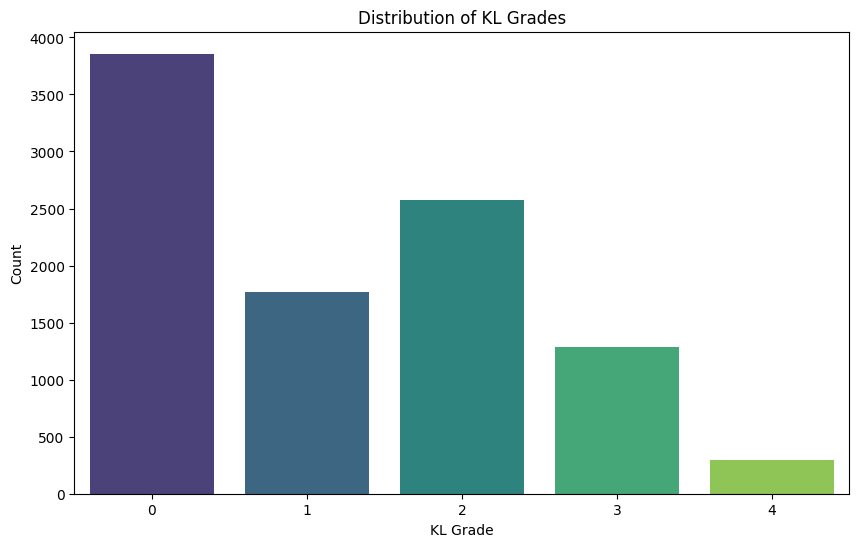

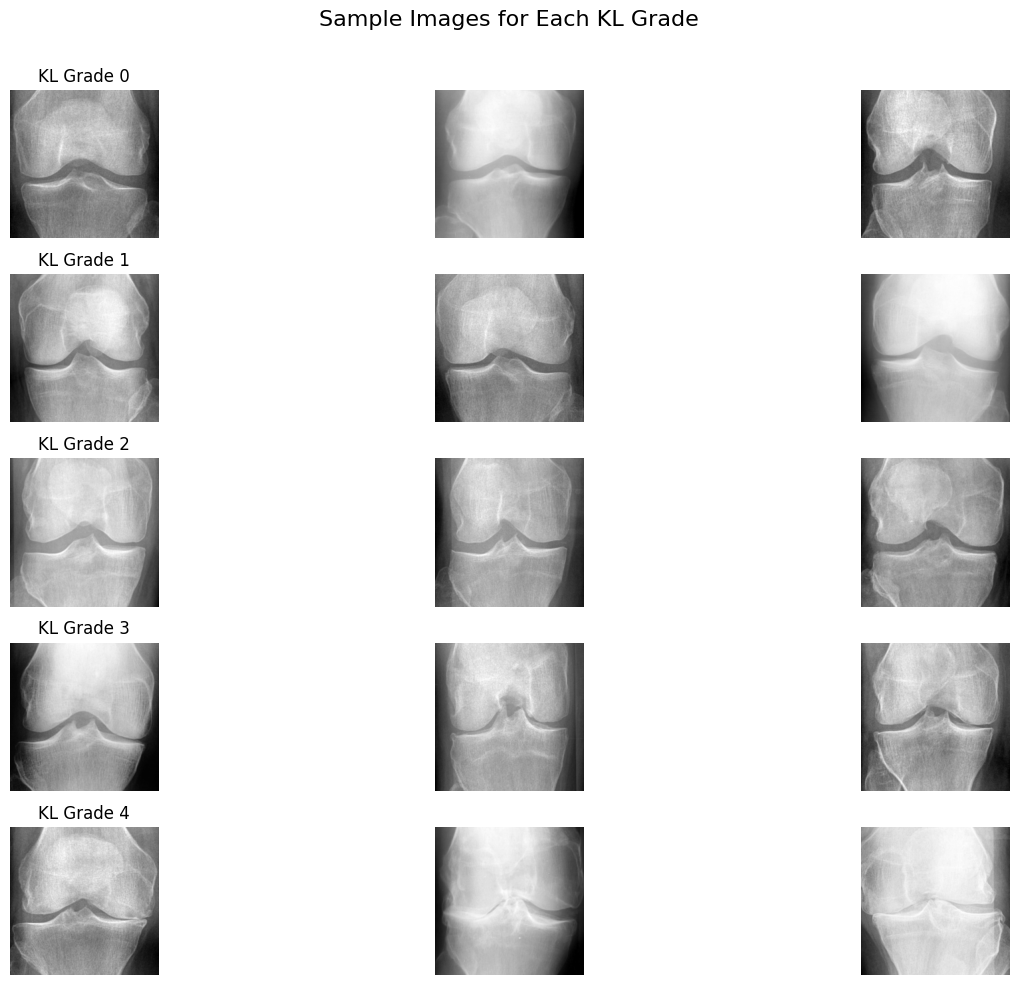

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image #Python Imaging Library used to open, manipulate, and save images

# Load the DataFrame (assuming it's saved as 'knee_oa_dataset.csv')
df = pd.read_csv('knee_oa_dataset.csv')

# 1. Basic Analysis
print("Dataset Overview:")
print(df.head())

print("\nTotal Images:", len(df))
print("\nClass Distribution:")
print(df['KL_Grade'].value_counts())

# 2. Plot Class Distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='KL_Grade', data=df, palette='viridis')
plt.title('Distribution of KL Grades')
plt.xlabel('KL Grade')
plt.ylabel('Count')
plt.show()

# 3. Display Sample Images from Each KL Grade
def display_sample_images(df, base_dir, n_samples=3):
    fig, axes = plt.subplots(5, n_samples, figsize=(15, 10))
    fig.suptitle('Sample Images for Each KL Grade', fontsize=16)

    for grade in range(5):  # KL Grades 0 to 4
        grade_df = df[df['KL_Grade'] == grade].sample(n_samples)
        for i, (index, row) in enumerate(grade_df.iterrows()):
            img = Image.open(row['Image_Path'])
            axes[grade, i].imshow(img, cmap='gray')
            axes[grade, i].axis('off')
            if i == 0:
                axes[grade, i].set_title(f'KL Grade {grade}')
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()

# Call the function to display images
display_sample_images(df, base_dir)

Data Augmentation

In [ ]:
import pandas as pd
from PIL import Image
from torchvision import transforms
from sklearn.model_selection import train_test_split
import os

# Step 1: Define Data Augmentation Transformations
augmentation = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.Resize((224, 224))
])

# Step 2: Balance the Dataset
def balance_dataset(df, base_dir, target_count=None):
    if target_count is None:
        target_count = df['KL_Grade'].value_counts().max()  # Use the highest class count as target

    balanced_data = []

    for grade in sorted(df['KL_Grade'].unique()):
        class_df = df[df['KL_Grade'] == grade]
        class_count = len(class_df)

        if class_count < target_count:
            augment_count = target_count - class_count
            augmented_samples = []

            for i in range(augment_count):
                sample = class_df.sample(1).iloc[0]
                img = Image.open(os.path.join(base_dir, sample['Image_Path']))

                # Apply augmentation
                augmented_img = augmentation(img)

                # Save augmented image (optional)
                augmented_img_path = sample['Image_Path'].replace('.jpg', f'_aug_{i}.jpg')
                augmented_img.save(os.path.join(base_dir, augmented_img_path))

                augmented_samples.append({'KL_Grade': grade, 'Image_Path': augmented_img_path})

            balanced_data.extend(class_df.to_dict('records'))
            balanced_data.extend(augmented_samples)
        else:
            balanced_data.extend(class_df.sample(target_count).to_dict('records'))

    return pd.DataFrame(balanced_data)

# Apply the Balancing Function
base_dir = "/content/base_dir/aug"  # Replace with your base directory path
balanced_df = balance_dataset(df, base_dir)

# Step 3: Train-Test-Validation Split (After Balancing)
train_df, temp_df = train_test_split(balanced_df, test_size=0.3, stratify=balanced_df['KL_Grade'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['KL_Grade'], random_state=42)

# Step 4: Print Dataset Sizes
print("Balanced Class Distribution:")
print(balanced_df['KL_Grade'].value_counts())
print("\nTraining set size:", len(train_df))
print("Validation set size:", len(val_df))
print("Test set size:", len(test_df))

Balanced Class Distribution:
KL_Grade
0    3857
1    3857
2    3857
3    3857
4    3857
Name: count, dtype: int64

Training set size: 13499
Validation set size: 2893
Test set size: 2893


EDA - Exploratory Data Analysis

<ipython-input-7-15acee433746>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='KL_Grade', data=balanced_df, palette='viridis')


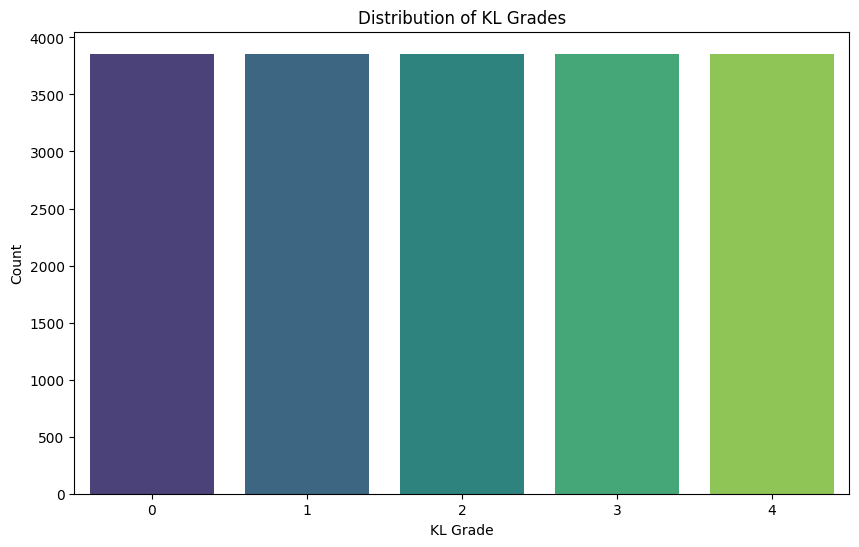

Chi-Square Test Result: Chi2ContingencyResult(statistic=0.0, pvalue=1.0, dof=0, expected_freq=array([[3857., 2578., 1770., 1286.,  295.]]))


In [ ]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy.stats import f_oneway, chi2_contingency
import seaborn as sns
# 1. Analyze Class Distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='KL_Grade', data=balanced_df, palette='viridis')
plt.title('Distribution of KL Grades')
plt.xlabel('KL Grade')
plt.ylabel('Count')
plt.show()

# 2. Feature Clustering (Using Brightness as Example)
if 'Brightness' in df.columns:
    kmeans = KMeans(n_clusters=5, random_state=42)
    df['Cluster'] = kmeans.fit_predict(df[['Brightness']])

    plt.figure(figsize=(8, 6))
    sns.scatterplot(x='KL_Grade', y='Brightness', hue='Cluster', palette='viridis', data=df)
    plt.title('Feature Clustering Based on Brightness')
    plt.xlabel('KL Grade')
    plt.ylabel('Brightness')
    plt.legend(title='Cluster')
    plt.show()

# 3. Statistical Analysis
# ANOVA Test for Brightness Across KL Grades
if 'Brightness' in df.columns:
    anova_result = f_oneway(
        df[df['KL_Grade'] == 0]['Brightness'],
        df[df['KL_Grade'] == 1]['Brightness'],
        df[df['KL_Grade'] == 2]['Brightness'],
        df[df['KL_Grade'] == 3]['Brightness'],
        df[df['KL_Grade'] == 4]['Brightness']
    )
    print("ANOVA Test Result:", anova_result)

# Chi-Square Test for Class Proportions
class_counts = df['KL_Grade'].value_counts()
chi2_result = chi2_contingency([class_counts.values])
print("Chi-Square Test Result:", chi2_result)

Feature engineering

In [ ]:
from PIL import Image
from torchvision import transforms
from sklearn.model_selection import train_test_split
# Import the Dataset class from torch.utils.data
from torch.utils.data import Dataset
# Custom Dataset Class
class KneeOADataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['Image_Path']
        image = Image.open(img_path).convert('RGB')
        kl_grade = self.dataframe.iloc[idx]['KL_Grade']

        if self.transform:
            image = self.transform(image)

        return image, kl_grade

Training the EfficientNet_B3 model

Downloading: "https://download.pytorch.org/models/efficientnet_b3_rwightman-b3899882.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b3_rwightman-b3899882.pth
100%|██████████| 47.2M/47.2M [00:00<00:00, 98.7MB/s]


Epoch 1/20, Loss: 0.6129, Accuracy: 75.97%
Epoch 2/20, Loss: 0.3949, Accuracy: 85.60%
Epoch 3/20, Loss: 0.2920, Accuracy: 89.67%
Epoch 4/20, Loss: 0.2234, Accuracy: 91.69%
Epoch 5/20, Loss: 0.1897, Accuracy: 93.09%
Epoch 6/20, Loss: 0.1392, Accuracy: 94.92%
Epoch 7/20, Loss: 0.1164, Accuracy: 95.89%
Epoch 8/20, Loss: 0.0905, Accuracy: 96.83%
Epoch 9/20, Loss: 0.0920, Accuracy: 96.70%
Epoch 10/20, Loss: 0.0736, Accuracy: 97.38%
Epoch 11/20, Loss: 0.0611, Accuracy: 97.87%
Epoch 12/20, Loss: 0.0677, Accuracy: 97.81%
Epoch 13/20, Loss: 0.0511, Accuracy: 98.27%
Epoch 14/20, Loss: 0.0624, Accuracy: 97.90%
Epoch 15/20, Loss: 0.0584, Accuracy: 97.96%
Epoch 16/20, Loss: 0.0460, Accuracy: 98.41%
Epoch 17/20, Loss: 0.0423, Accuracy: 98.47%
Epoch 18/20, Loss: 0.0511, Accuracy: 98.13%
Epoch 19/20, Loss: 0.0451, Accuracy: 98.45%
Epoch 20/20, Loss: 0.0380, Accuracy: 98.70%
Classification Report:
              precision    recall  f1-score   support

  KL Grade 0       0.88      0.84      0.86       5

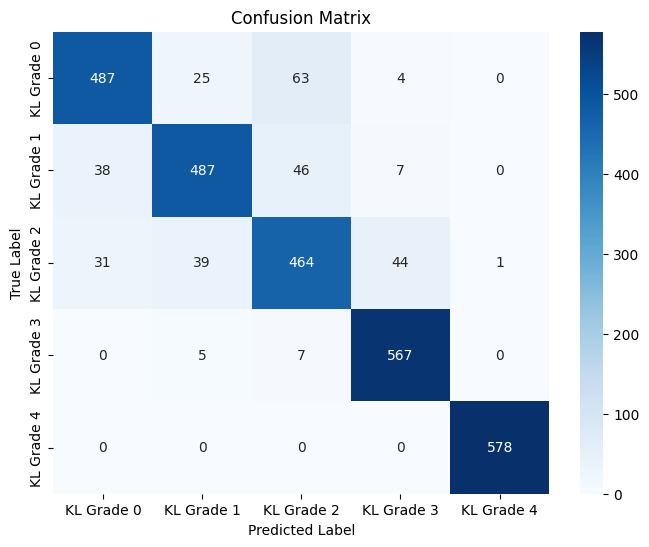

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import pairwise_distances, classification_report, confusion_matrix
from torchvision import transforms
# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to a consistent size
    transforms.ToTensor(),          # Convert PIL images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize image data
])
# Load Dataset
train_dataset = KneeOADataset(train_df, transform=transform)
val_dataset = KneeOADataset(val_df, transform=transform)
test_dataset = KneeOADataset(test_df, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Load Pre-trained Model (EfficientNet for Better Performance)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = models.efficientnet_b3(weights=models.EfficientNet_B3_Weights.DEFAULT)

# Modify the final layer for KL Grade classification (5 classes)
num_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_features, 5)
model = model.to(device)

# Train the model (always train instead of checking for an existing model file)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 20

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        # Compute accuracy
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = correct / total * 100
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%")

# Save trained model
torch.save(model.state_dict(), "best_knee_oa_model.pth")

# Load the best saved model
model.load_state_dict(torch.load("best_knee_oa_model.pth"))
model.eval()

# Define Evaluation Metrics
def evaluate_model(model, test_loader):
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return all_labels, all_preds

# Evaluate the model
all_labels, all_preds = evaluate_model(model, test_loader)

# 1. Classification Report
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=[f'KL Grade {i}' for i in range(5)]))

# 2. Confusion Matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=[f'KL Grade {i}' for i in range(5)], yticklabels=[f'KL Grade {i}' for i in range(5)])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [ ]:
pip install torchcam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 108.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 93.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 69.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 53.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
from torchcam.methods import GradCAM
from torchvision.transforms.functional import to_pil_image
import matplotlib.pyplot as plt

In [ ]:
# Get the target layer name for EfficientNet B3 (usually the last Conv layer)
cam_extractor = GradCAM(model, target_layer="features.8")  # EfficientNetB3 last conv block

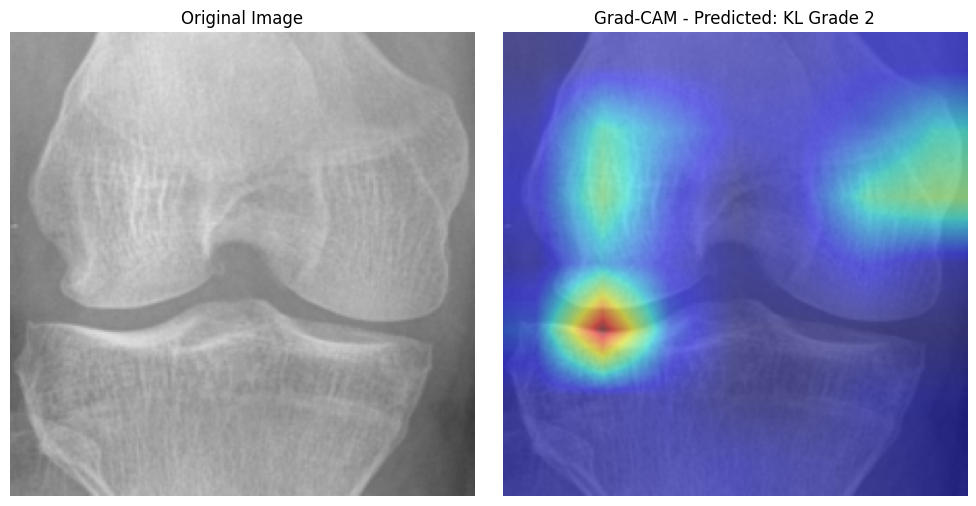

In [ ]:
from PIL import Image
import torch

# Load and prepare image
img_path = test_df.sample(1).iloc[0]["Image_Path"]
img = Image.open(img_path).convert("RGB")
input_tensor = transform(img).unsqueeze(0).to(device)

# Forward pass
model.eval()
out = model(input_tensor)
pred = out.argmax(dim=1).item()

# Get CAM
activation_map = cam_extractor(pred, out)

# Show Grad-CAM
heatmap = activation_map[0].cpu()
result_img = to_pil_image(heatmap, mode='F')

# Resize CAM to match original image
resized_heatmap = transforms.Resize(img.size[::-1])(heatmap.unsqueeze(0))
plt.figure(figsize=(10, 5))

# Plot original image
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title("Original Image")
plt.axis("off")

# Plot heatmap over image
plt.subplot(1, 2, 2)
plt.imshow(img)
plt.imshow(resized_heatmap.squeeze(), cmap='jet', alpha=0.5)
plt.title(f"Grad-CAM - Predicted: KL Grade {pred}")
plt.axis("off")

plt.tight_layout()
plt.show()

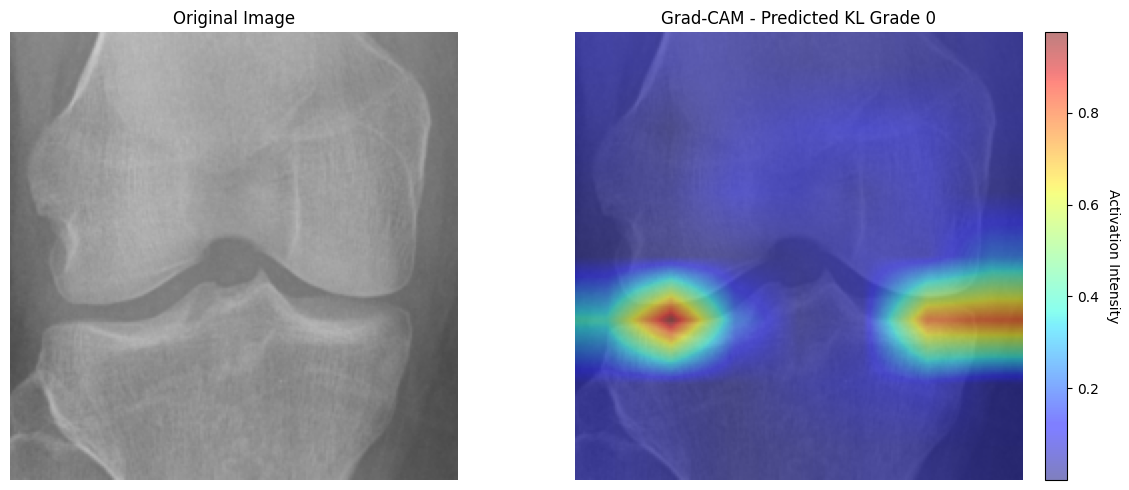

In [ ]:
import matplotlib.colorbar as cbar

# Generate Grad-CAM heatmap
cam_extractor = GradCAM(model, target_layer="features.8")
img_path = test_df.sample(1).iloc[0]['Image_Path']
img = Image.open(img_path).convert('RGB')
input_tensor = transform(img).unsqueeze(0).to(device)
output = model(input_tensor)
pred_class = output.argmax(dim=1).item()

activation_map = cam_extractor(pred_class, output)[0].cpu()
resized_heatmap = transforms.Resize(img.size[::-1])(activation_map.unsqueeze(0)).squeeze()

# Plot original and Grad-CAM with colorbar
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Original image
ax[0].imshow(img)
ax[0].set_title("Original Image")
ax[0].axis("off")

# Grad-CAM heatmap overlay with colorbar
heatmap = ax[1].imshow(img)
heatmap_overlay = ax[1].imshow(resized_heatmap, cmap='jet', alpha=0.5)
ax[1].set_title(f"Grad-CAM - Predicted KL Grade {pred_class}")
ax[1].axis("off")

# Add colorbar
cbar = fig.colorbar(heatmap_overlay, ax=ax[1], fraction=0.046, pad=0.04)
cbar.set_label("Activation Intensity", rotation=270, labelpad=15)

plt.tight_layout()
plt.show()
